# NN draw

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from functools import partial

In [3]:
from rebayes_mini.methods import low_rank_filter_revised as lrkf

## The model objective function

In [4]:
class TrueMLP(nn.Module):
    n_hidden: int = 50
    initializer = nn.initializers.normal

    def setup(self):
        self.hidden_1 = nn.Dense(
            50,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

        self.hidden_2 = nn.Dense(50,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

        self.last = nn.Dense(1,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

    def __call__(self, x):
        x = self.hidden_1(x)
        x = nn.relu(x)
        x = self.hidden_2(x)
        x = nn.relu(x)
        x = self.last(x) / 100
        return x

In [5]:
key = jax.random.PRNGKey(314)
key_init, key_surrogate = jax.random.split(key)

In [442]:
dim = 20 # change to 200
X_init = jnp.ones((1, dim))

base_model = TrueMLP()
params_base = base_model.init(key_init, X_init)

## Surrogate model

In [443]:
class MLP(nn.Module):
    n_hidden: int = 128

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(1)(x)
        return x

In [475]:
surrogate = MLP()

rank = 100
key_init, key_train = jax.random.split(key_surrogate)
params_init = surrogate.init(key_init, X_init)
agent = lrkf.GaussianFilter(surrogate.apply, dynamics_covariance=1e-7, rank=rank)
bel_init = agent.init_bel(params_init)

## Iterate

## Step 1

In [476]:
from jaxopt import ProjectedGradient

In [477]:
def opt_step(x, params):
    """
    Function to maximise
    """
    evalfn = agent.link_fn(params, x).squeeze()
    return -evalfn

def projection(params, hparams):
    return jnp.clip(params, 0.0, 1.0)

def soft_project(params, hparams):
    alpha = 100.0
    lower_bounds = 0.0
    upper_bounds = 1.0
    # Sigmoid-based smooth projection
    sigm = jax.nn.sigmoid(alpha * (params - lower_bounds) / (upper_bounds - lower_bounds))
    return lower_bounds + (upper_bounds - lower_bounds) * sigm

def minimise_project(params, guess_init):
    opt = ProjectedGradient(
        fun=partial(opt_step, params=params),
        projection=projection,  # Enforce boundary constraints
        stepsize=1e-5,
        # tol=1e-5
    )
    
    res = opt.run(init_params=guess_init)
    x_next = res.params
    return x_next


def minimise_project_random(key, params):
    x_samples = jax.random.uniform(key, (500, dim))
    evals = agent.link_fn(params, x_samples)
    return x_samples[evals.argmax()]

In [478]:
n_params = len(bel_init.mean)

In [479]:
key_step = jax.random.fold_in(key_train, 1)

In [480]:
key_sample, key_init = jax.random.split(key_step) # should be key_step
guess_init = jax.random.uniform(key_sample, (dim,))

In [481]:
eps_sample = jax.random.normal(key_init, (rank,))
params_sample = jnp.einsum("ji,j->i", bel_init.low_rank, eps_sample) + bel_init.mean

In [482]:
x_next = minimise_project(params_sample, guess_init)

In [483]:
y_next = base_model.apply(params_base, x_next)
y_next

Array([-0.29422188], dtype=float32)

## Step 2

In [484]:
bel = agent.predict(bel_init)
bel = agent.update(bel, y_next, x_next)

In [485]:
key_step = jax.random.fold_in(key_train, 2)
key_sample, key_params = jax.random.split(key_step) 

In [486]:
eps_sample = jax.random.normal(key_params, (rank,))
params_sample = jnp.einsum("ji,j->i", bel.low_rank, eps_sample) + bel.mean

In [487]:
x_next = minimise_project(params_sample, guess_init)

In [488]:
y_next = base_model.apply(params_base, x_next)
y_next

Array([-0.14527526], dtype=float32)

## Step t

In [517]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

In [520]:
y_hist = np.zeros(500)
for t in range(500):
    bel = agent.predict(bel)
    bel = agent.update(bel, y_next, x_next)
    
    key_step = jax.random.fold_in(key_train, t)
    key_sample, key_params = jax.random.split(key_step)
    
    eps_sample = jax.random.normal(key_params, (rank,))
    params_sample = jnp.einsum("ji,j->i", bel.low_rank, eps_sample) + bel.mean
    
    # x_next = minimise_project(params_sample, guess_init)
    x_next = minimise_project_random(key_sample, params_sample)
    y_next = base_model.apply(params_base, x_next)
    print(t, y_next.item(), end="\r")
    
    y_hist[t] = y_next.item()

499 0.63200002908706672033

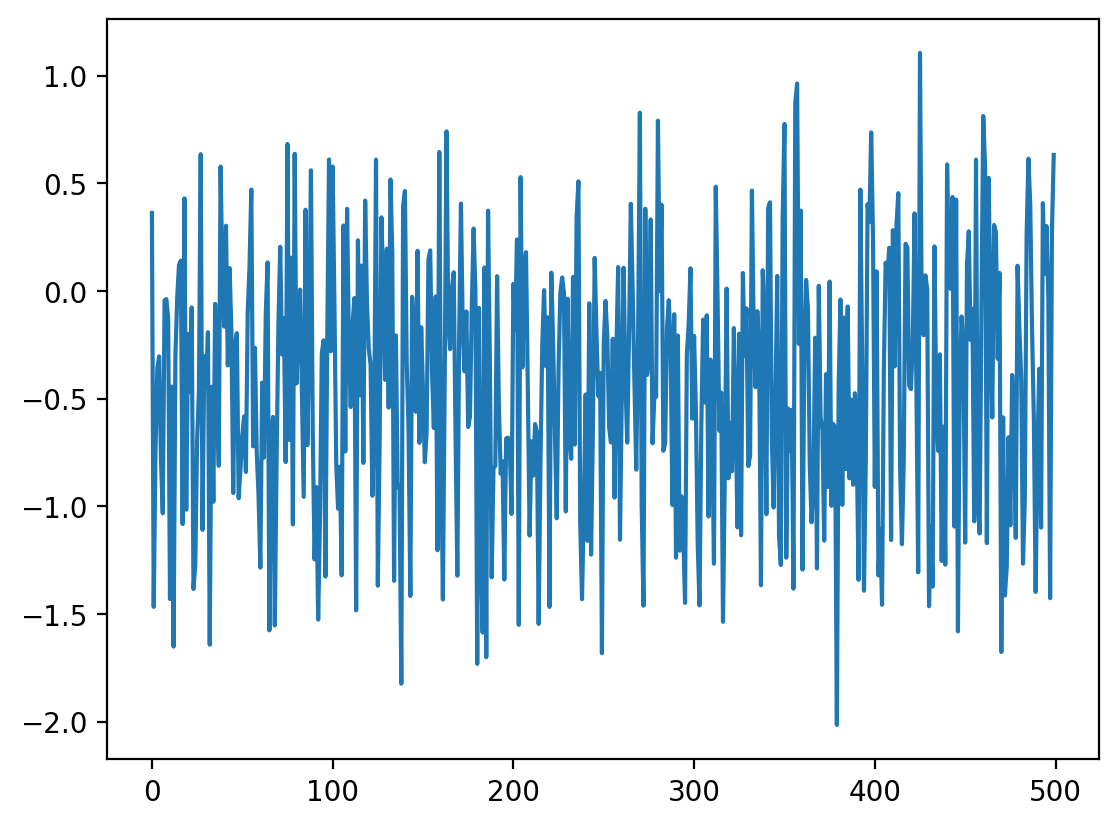

In [521]:
plt.plot(y_hist)

## The true optimum

In [536]:
opt = ProjectedGradient(
    fun=lambda x: -base_model.apply(params_base, x).squeeze(),
    projection=projection,  # Enforce boundary constraints
    stepsize=1e-6,
    # tol=1e-5
    maxiter=10_000
)

res = opt.run(init_params=guess_init)

In [537]:
res.params

Array([0.9368911 , 1.        , 0.        , 1.        , 1.        ,
       1.        , 1.        , 0.        , 1.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.16390862, 0.        , 0.        , 0.9662215 , 0.30982894],      dtype=float32)

In [538]:
base_model.apply(params_base, res.params)

Array([2.0418732], dtype=float32)